## Loading data

In [16]:
import pandas as pd

In [17]:
import numpy as np

In [18]:
data = pd.read_csv('amazon_baby_subset.csv')
data.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


## Remove Punctuation

In [19]:
import string

def remove_punctuation(text):
    if isinstance(text, str):
        return text.translate(None, string.punctuation)
    return str(text)

In [20]:
data = data.fillna({'review':''})
data['review_clean'] = data['review'].map(lambda s: remove_punctuation(s))
data.head()

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


## Reading Important Words

In [21]:
def read_index(filename):
    with open(filename, 'r') as f:
        first_line = f.readline()
    first_line = first_line.translate(None,'[]"').strip().split(',')
    first_line = [x.strip() for x in first_line]
    return first_line

In [22]:
important_words = read_index('important_words.json')
print important_words[:5]

['baby', 'one', 'great', 'love', 'use']


## Adding Word Counts

In [23]:
for word in important_words:
    data[word] = data['review_clean'].apply(lambda s : s.split().count(word))

## Split data on train/valid

In [24]:
def read_index(filename):
    with open(filename, 'r') as f:
        first_line = f.readline()
    first_line = first_line.translate(None,'[]"').strip().split(',')
    first_line = [x.strip() for x in first_line]
    return first_line

train_idx = read_index('train-idx.json')
valid_idx = read_index('valid-idx.json')
train_idx = [int(x) for x in train_idx]
valid_idx = [int(x) for x in valid_idx]

In [25]:
train_data = data.iloc[train_idx]
valid_data = data.iloc[valid_idx]
train_data.reset_index(inplace=True)
valid_data.reset_index(inplace=True)

## Convert data to multidementional array

In [26]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [28]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(valid_data, important_words, 'sentiment')

/Users/oleksiirenov/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


## Quiz question: In Module 3 assignment, there were 194 features (an intercept + one feature for each of the 193 important words). In this assignment, we will use stochastic gradient ascent to train the classifier using logistic regression. How does the changing the solver to stochastic gradient ascent affect the number of features?



the same number of features should be

# Building a Logistic Regression

In [29]:
import math

def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    predictions = map(lambda s: 1./(1.+math.exp(-s)), score)
    
    return predictions

In [30]:
def feature_derivative(errors, feature):     
    derivative = np.sum(np.multiply(errors, feature))
    return derivative

In [31]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp

## Quiz question: Recall from the lecture and the earlier assignment, the log likelihood (without the averaging term) is given by

### How are the functions ll(w) and ll_A(w) related?

ll(w) = N * ll_A(w)

In [32]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print "Gradient single data point: %s" % gradient_single_data_point
print "           --> Should print 0.0"

Gradient single data point: 0.0
           --> Should print 0.0


##Quiz Question: The code block above computed the derivative is this a scalar or 194-dimension vector?

scalar, why?

In [33]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print "Gradient mini-batch data points: %s" % gradient_mini_batch
print "                --> Should print 1.0"

Gradient mini-batch data points: 1.0
                --> Should print 1.0


## Quiz Question: The code block above compute
## for j = 10, i = 10, and B = 10. Is this a scalar or a 194-dimensional vector?

scalar

## Quiz Question: For what value of B is the term the same as the full gradient?

When Batch size eaual to size of all train data.

## Implementing Stochastic Gradient Ascent

In [80]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    coefficients = np.array(initial_coefficients)
    sentiment = np.array(sentiment)
    np.random.seed(seed=1)
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        predictions = predict_probability(feature_matrix[i:(i+batch_size),:], coefficients)

        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        indicator = np.array(1 * (sentiment[i:i+batch_size] == 1))

        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size, j])
            # Compute the product of the step size, the derivative, and
            # the **normalization constant** (1./batch_size)
            coefficients[j] += step_size * derivative * 1./ batch_size 

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print 'Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp)  

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i + batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0                

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

## Quiz Question: For what value of batch size B above is the stochastic gradient ascent function logistic_regression_SG act as a standard gradient ascent algorithm?

For batch size equal length of train data

In [81]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = 1
max_iter = 10
log_reg = logistic_regression_SG(feature_matrix_train, sentiment_train, [0.] * feature_matrix_train.shape[1],
                                 step_size, batch_size, max_iter)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


##Quiz Question. When you set batch_size = 1, as each iteration passes, how does the average log likelihood in the batch change?

In [82]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = feature_matrix_train.shape[0]
max_iter = 200
batch_grad = logistic_regression_SG(feature_matrix_train, sentiment_train, [0.] * feature_matrix_train.shape[1],
                                    step_size, batch_size, max_iter)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

## Quiz Question. When you set batch_size = len(train_data), as each iteration passes, how does the average log likelihood in the batch change?

It monotonically decreases.

## Make Passes Over Dataset

## Quiz Question Suppose that we run stochastic gradient ascent with a batch size of 100. How many gradient updates are performed at the end of two passes over a dataset consisting of 50000 data points?

In [83]:
50000 * 2 /100

1000

In [84]:
step_size=1e-1
batch_size=100
max_iter = 10 * feature_matrix_train.shape[0] / batch_size

In [85]:
sg1 = logistic_regression_SG(feature_matrix_train, sentiment_train, [0.] * feature_matrix_train.shape[1],
                                 step_size, batch_size, max_iter)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data points  [01100:01

## Smoothing Window

In [86]:
def movingaverage(interval, window_size):
    window = npy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

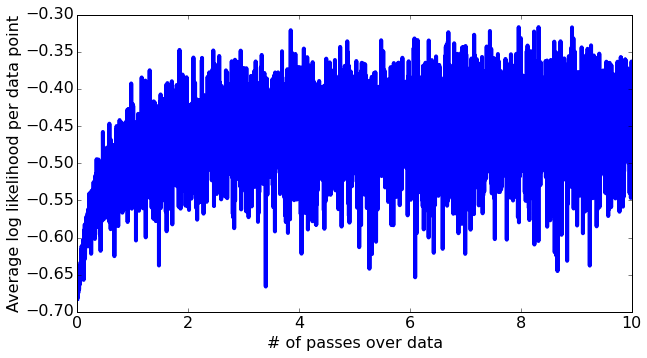

In [89]:
make_plot(sg1[1], feature_matrix_train.shape[0], batch_size)

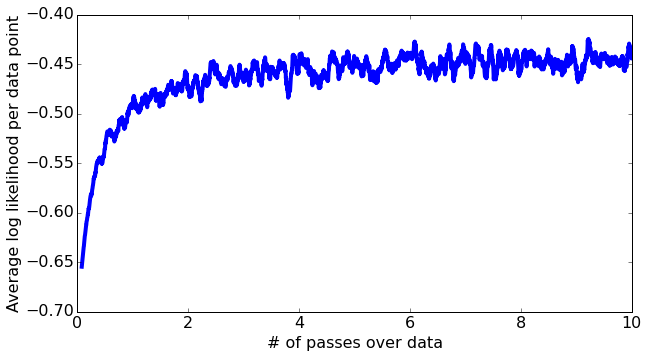

In [90]:
make_plot(sg1[1], feature_matrix_train.shape[0], batch_size, 40)

## Stochastic gradient ascent vs batch gradient ascent

In [91]:
step_size = 0.1
batch_size = 100
max_iter = 200 * feature_matrix_train.shape[0] / batch_size
c_sg = logistic_regression_SG(feature_matrix_train, sentiment_train, [0.] * feature_matrix_train.shape[1],
                                 step_size, batch_size, max_iter)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

In [92]:
step_size = 0.1
batch_size = feature_matrix_train.shape[0]
max_iter = 200
c_bg = logistic_regression_SG(feature_matrix_train, sentiment_train, [0.] * feature_matrix_train.shape[1],
                                 step_size, batch_size, max_iter)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.69109040
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.68907589
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.68710116
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.68516409
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.68326284
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.68139582
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.67956161
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.67775898
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.67598680
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.67424406
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.67252984
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

## Quiz Question: In the figure above, how many passes does batch gradient ascent need to achieve a similar log likelihood as stochastic gradient ascent?

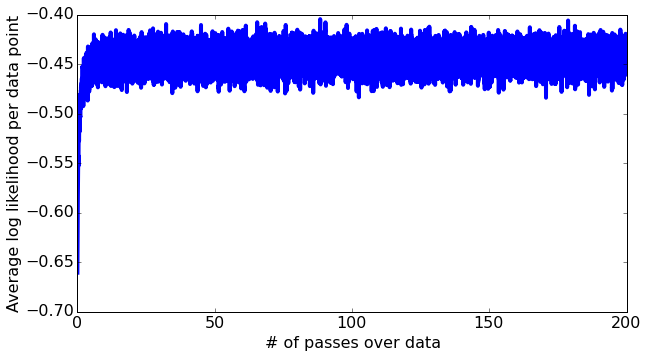

In [93]:
make_plot(c_sg[1], feature_matrix_train.shape[0], 100, 30)

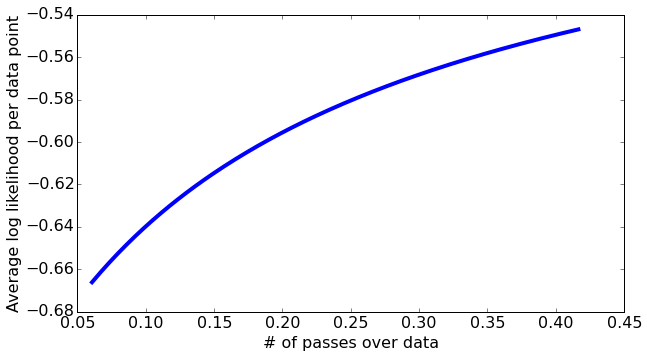

In [94]:
make_plot(c_bg[1], feature_matrix_train.shape[0], 100, 30)

## Explore the effects of step sizes on stochastic gradient ascent



In [102]:
step_size = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
batch_size=100
max_iter = 10 * feature_matrix_train.shape[0] / batch_size
result = []
for step in step_size:
    c_sg = logistic_regression_SG(feature_matrix_train, sentiment_train, [0.] * feature_matrix_train.shape[1],
                                 step, batch_size, max_iter)
    result.append({'step_size' : step, 'max_score' : max(c_sg[1]), 'last_score' : c_sg[1][-1]})

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [01100:01

OverflowError: math range error

In [103]:
print result

[{'step_size': 0.0001, 'max_score': -0.67952570296468051, 'last_score': -0.68334170111550041}, {'step_size': 0.001, 'max_score': -0.59699819126636089, 'last_score': -0.62380603334837204}, {'step_size': 0.01, 'max_score': -0.41522804686230108, 'last_score': -0.49267051163027548}, {'step_size': 0.1, 'max_score': -0.31675027082736262, 'last_score': -0.40492494549651359}, {'step_size': 1.0, 'max_score': -0.25880083654357927, 'last_score': -0.3862633719208281}, {'step_size': 10.0, 'max_score': -0.18246219632462124, 'last_score': -0.48217136475189859}]


## Which of the following is the worst step size? Pick the step size that results in the lowest log likelihood in the end.

In [106]:
reduce(lambda a,b : a if a['last_score'] < b['last_score'] else b, filter(lambda s: s['step_size'] not in [0.0001, 0.001],result))

{'last_score': -0.49267051163027548,
 'max_score': -0.41522804686230108,
 'step_size': 0.01}

## Which of the following is the best step size? Pick the step size that results in the highest log likelihood in the end.

In [107]:
reduce(lambda a,b : a if a['last_score'] > b['last_score'] else b, result)

{'last_score': -0.3862633719208281,
 'max_score': -0.25880083654357927,
 'step_size': 1.0}